In [65]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
from torch.nn import KLDivLoss
from torch.nn.functional import interpolate
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [66]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
# Interpolating to image size used in experiments
img_tensor = interpolate(img_tensor, size=(3, 128, 128))
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape
print(img_tensor.shape)

torch.Size([16, 4, 3, 128, 128])


In [67]:
patch_size = (12, 12)
hist_norm_p = float('inf')  # 0, 1, 2, float('inf')
v_min = 0.0
v_max = 2.0
n_bins = 10  # 100 / 250

In [68]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

In [69]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

In [70]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

In [71]:
import numpy as np
from kornia.filters import sobel
from src.losses.utils import differentiable_histogram

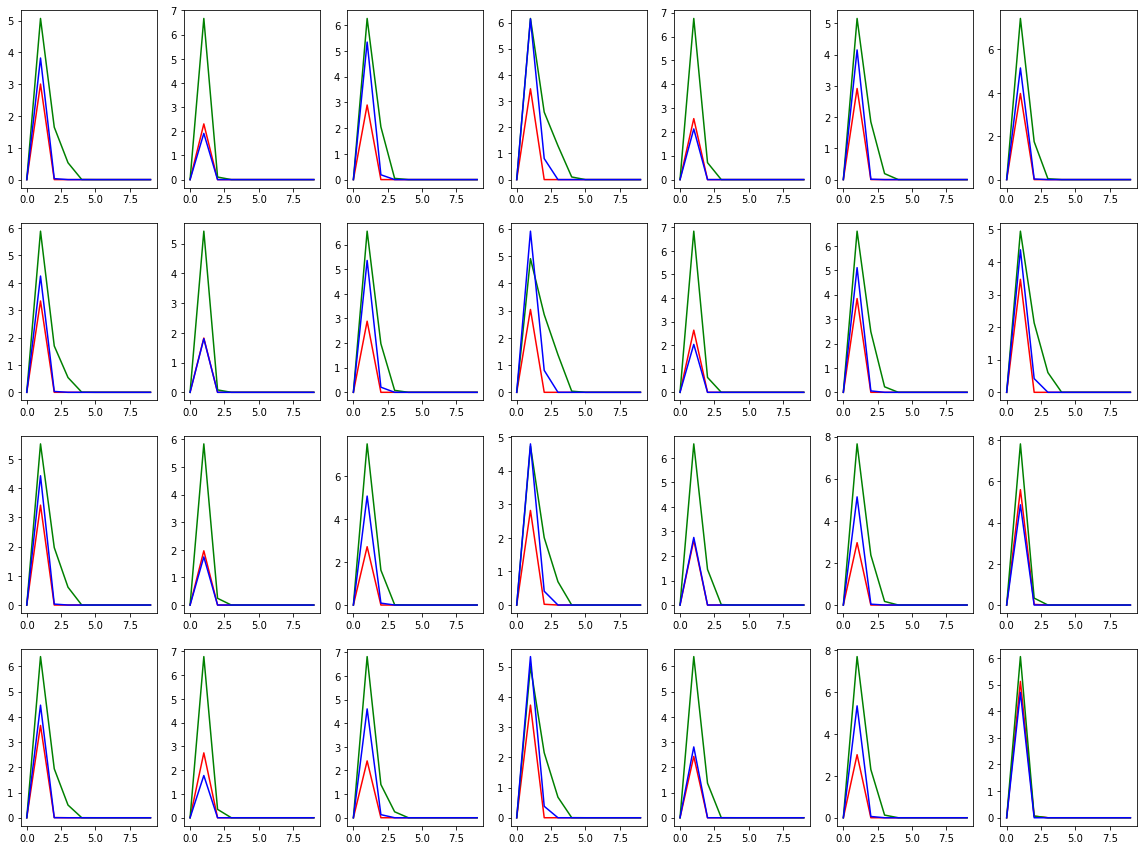

In [72]:
perfect_mag = sobel(perfect_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))
perfect_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_mag_hists[n, t, k, c] = differentiable_histogram(perfect_mag[n, t, k, c],
                                                                         bins=n_bins, min=0.0, max=1.0)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 2], color='blue')

tensor([[0.8203, 1.2526, 0.2887, 1.2569, 0.0922, 1.4433, 2.4828],
        [0.3701, 0.4238, 0.9749, 1.1124, 0.8224, 1.0520, 2.8787],
        [0.8748, 0.9351, 0.6999, 0.9132, 0.2160, 0.2118, 1.7723]])
tensor(0.9950)


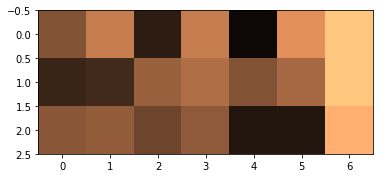

In [73]:
perfect_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_mag_dist[k, t] = torch.norm(perfect_mag_hists[0, t:t+1, k, :] - perfect_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(perfect_mag_dist.T)
        
plt.imshow(perfect_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(perfect_mag_dist.mean())

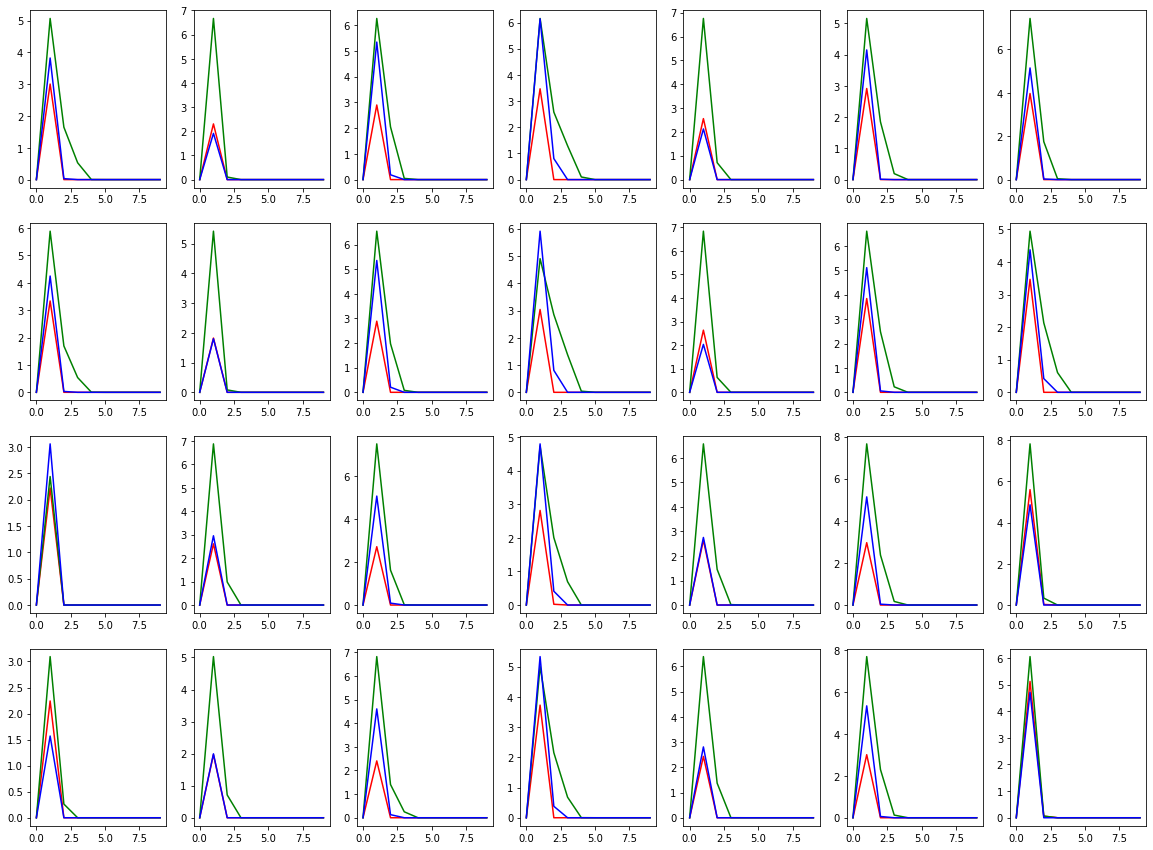

In [74]:
bad_mag = sobel(bad_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

bad_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_mag_hists[n, t, k, c] = differentiable_histogram(bad_mag[n, t, k, c],
                                                                     bins=n_bins, min=0.0, max=1.0)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 2], color='blue')

tensor([[0.8203, 1.2526, 0.2887, 1.2569, 0.0922, 1.4433, 2.4828],
        [3.4484, 1.4589, 0.9749, 1.1124, 0.8224, 1.0520, 2.8787],
        [1.4886, 1.8490, 0.6999, 0.9132, 0.2160, 0.2118, 1.7723]])
tensor(1.2636)


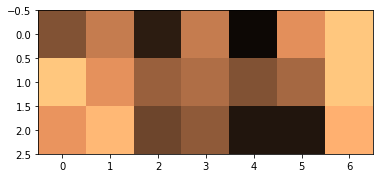

In [75]:
bad_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        bad_mag_dist[k, t] = torch.norm(bad_mag_hists[0, t:t+1, k, :] - bad_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(bad_mag_dist.T)

plt.imshow(bad_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(bad_mag_dist.mean())

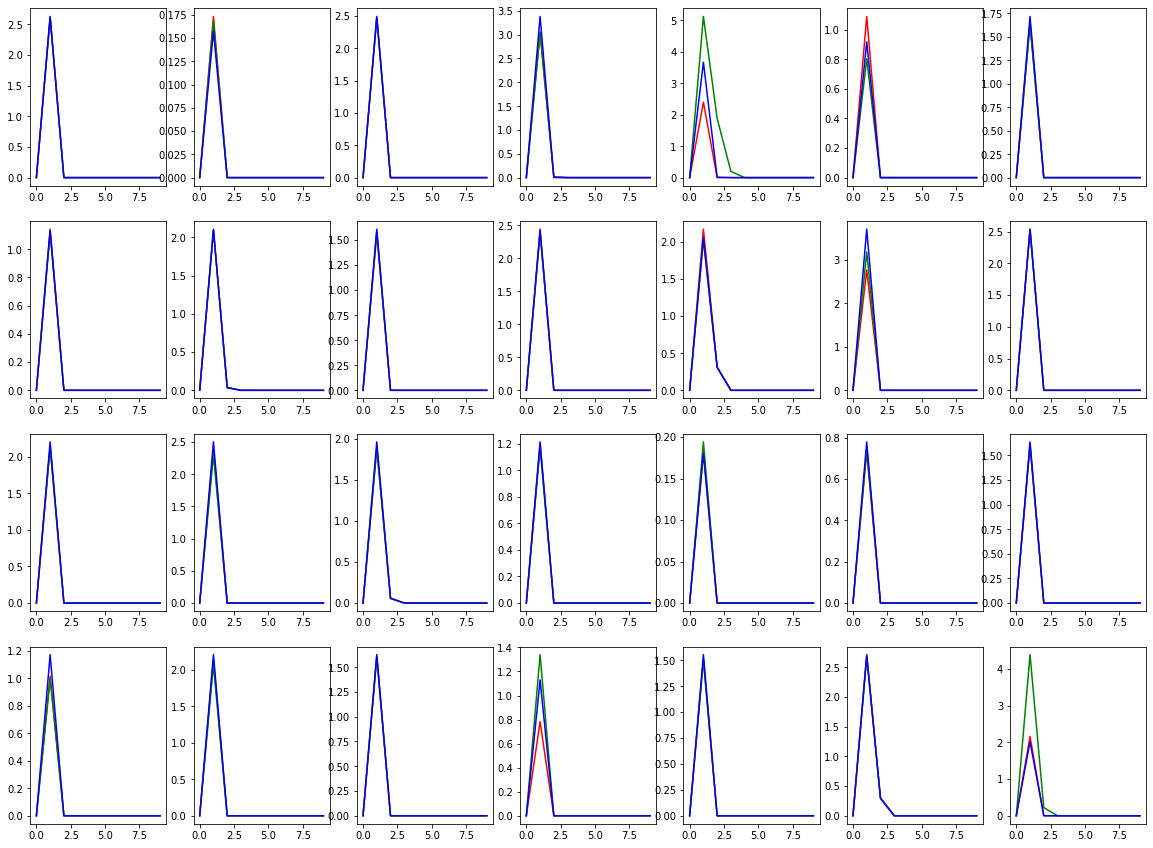

In [76]:
random_mag = sobel(random_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

random_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_mag_hists[n, t, k, c] = differentiable_histogram(random_mag[n, t, k, c],
                                                                        bins=n_bins, min=0.0, max=1.0)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 2], color='blue')

tensor([[1.4921, 1.9505, 0.9289, 0.9394, 3.0981, 2.7863, 0.8961],
        [1.0655, 0.3939, 0.3518, 1.2276, 1.9868, 2.9238, 0.9421],
        [1.1322, 0.2917, 0.3324, 0.4180, 1.3747, 1.9772, 2.7752]])
tensor(1.3945)


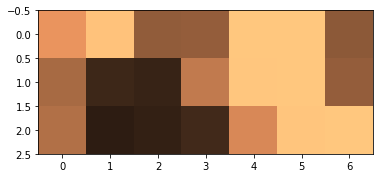

In [77]:
random_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        random_mag_dist[k, t] = torch.norm(random_mag_hists[0, t:t+1, k, :] - random_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(random_mag_dist.T)
        
plt.imshow(random_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(random_mag_dist.mean())